In [ ]:
from app_model import MModel,DeepModelGRU
import pandas as pd
import joblib
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix,f1_score,precision_recall_curve
from sklearn.feature_selection import chi2, SelectKBest
import matplotlib.pyplot as plt
from app_training import Training
from app_utils import *
from sklearn.model_selection import train_test_split
from app_dataset import SentimentDataset
from torch.utils.data import DataLoader
import torch
import multiprocessing


#### En nuestro pipeline utilizamos **imbalanced-learn (IMB)** para manejar el **balanceo de clases** y mejorar el rendimiento del modelo en datos desbalanceados.  

  **Estrategias Implementadas**  
  **Pesos en el criterio de `class_weight`**  
- En **Logistic Regression**, se ajustaron los pesos de las clases (`class_weight=pes_weigth`) para mitigar el sesgo hacia la clase mayoritaria cuando se utilizó **TF-IDF** como vectorizador de texto.  

 **Normalización y SMOTETomek en SVM**  
- En el caso de **SVM**, trabajamos con **CountVectorizer**, normalizando los datos para mejorar la estabilidad del modelo.  
- Además, aplicamos **SMOTETomek**, una combinación de **sobremuestreo con SMOTE y submuestreo con Tomek Links**, con el objetivo de equilibrar la distribución de clases y reducir la redundancia en los datos.  

 *1️- vect__max_df = 0.9*

   Filtra palabras que aparecen en más del 90% de los documentos.
   Mejora la discriminación entre clases al eliminar ruido.

*2️- vect__min_df = 3*

  Solo incluye palabras que aparecen en al menos 3 documentos.
  Filtra palabras poco frecuentes que podrían ser ruido y no aportar generalización.
  Evita el sobreajuste con términos de escasa frecuencia.

 *3️- vect__max_features = [9000, 10000]*
   
   Usa un vocabulario amplio pero controlado, evitando dimensiones excesivas.
   Mayor número de features puede mejorar el ROC-AUC porque permite capturar más patrones.
 *4️- vect__ngram_range = (1,2)(1,3)*

   Se implementaron  Bigramas y Trigramas → Capturan contexto y expresiones clave.
   Aumenta la riqueza de la representación y mejora el desempeño del modelo al capturar dependencias entre palabras.
   
 *5- clf__C = [0.5, 0.7, 0.9]*
   
   C es el parámetro de regularización:
   Probamos valores intermedios que permiten un mejor equilibrio entre sesgo y varianza.
   Mejora ROC-AUC porque permite capturar patrones sin memorizar el ruido

In [3]:
df_train=pd.read_csv('./datasets/train_process_dataset.csv')
df_test=pd.read_csv('./datasets/test_process_dataset.csv')

In [ ]:
model=MModel(df_train,df_test)
model.train_()

In [ ]:
model=MModel(df_train,df_test)
model.train_()


 Entrenando modelo: TF-IDF
n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 237069
max_resources_: 237069
aggressive_elimination: False
factor: 10
----------
iter: 0
n_candidates: 6
n_resources: 237069
Fitting 3 folds for each of 6 candidates, totalling 18 fits


##### 🏆 Mejor Modelo Encontrado  

Después de evaluar múltiples configuraciones, el mejor modelo fue obtenido con **TF-IDF**, alcanzando un **ROC-AUC de 0.8886**.  

🔹 **Modelo seleccionado**:  
📌 `best_model_TF-IDF_0.8886.pkl`  


 **Uso de TF-IDF**: Mejor representación del texto al ponderar palabras según su importancia.  
 **Ajuste de hiperparámetros**: Se optimizaron los valores de `max_df`, `min_df`, `ngram_range` y `C` para mejorar la discriminación de clases.  
 **Balanceo de clases**: Se utilizaron técnicas de ajuste de pesos (`class_weight='balanced'`) para mejorar la predicción en clases minoritarias.  


In [16]:
model = joblib.load("./model/best_model_TF-IDF_0.8886.pkl")
X_test = np.array(df_test['reviewTextProcess'].astype(str))
y_test = np.array(df_test['sentiment'])

y_scores = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)


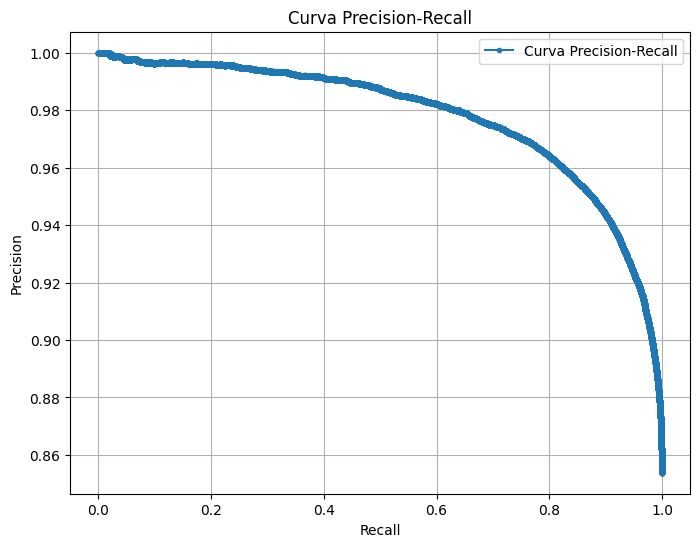

In [17]:
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid()
plt.show()

#####  Selección del Mejor Umbral Basado en Precision-Recall  

Para optimizar la clasificación, utilizamos la **curva Precision-Recall** y seleccionamos el **mejor umbral (`threshold`)** basado en el equilibrio entre **precisión y recall**.  

**Cálculo del Mejor Umbral**  
El umbral óptimo se encuentra maximizando el producto de precisión y recall:  


In [18]:
best_threshold = thresholds[np.argmax(precision * recall)]
print(f"Mejor umbral encontrado: {best_threshold}")

Mejor umbral encontrado: 0.0383023803832272


In [19]:
y_pred_adjusted = (y_scores >= best_threshold).astype(int)

print("\nClassification Report con nuevo umbral:")
print(classification_report(y_test, y_pred_adjusted))

print("\nConfusion Matrix con nuevo umbral:")
print(confusion_matrix(y_test, y_pred_adjusted))


Classification Report con nuevo umbral:
              precision    recall  f1-score   support

           0       0.75      0.41      0.53      8664
           1       0.91      0.98      0.94     50604

    accuracy                           0.89     59268
   macro avg       0.83      0.69      0.73     59268
weighted avg       0.88      0.89      0.88     59268


Confusion Matrix con nuevo umbral:
[[ 3535  5129]
 [ 1188 49416]]


**Clase 1 (positiva) se detecta con alta recall (98%)**, lo que significa que casi todos los positivos se identifican correctamente.  
**Clase 0 (negativa) tiene recall más bajo (41%)**, indicando que **muchos falsos positivos** están presentes.  
**El ajuste del umbral ha permitido mejorar el balance de predicciones** sin sacrificar demasiado la precisión general del modelo.  
El modelo detecta bien la clase 1, pero le cuesta detectar la clase 0 (falsos positivos elevados).
Si la clase 0 es importante, podrías ajustar el umbral para mejorar su recall (pero esto afectaría la clase 1), en ese caso tendriamos que determinar que es mas importante para nosotros si fallar en la clase Negtiva o la clase Positiva. Igual es importante destacar que el 75% de las veces que el modelo dice que es 0, es 0.


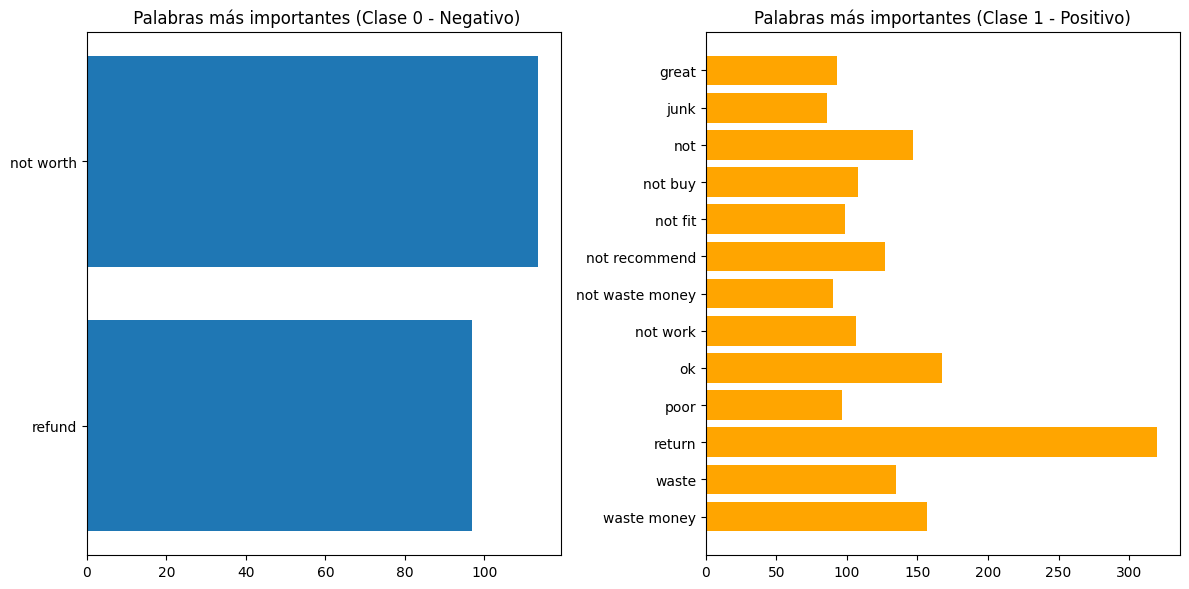

In [27]:
vectorizer = model['vect']
X_test_transformed = vectorizer.transform(X_test)  

chi2_scores, p_values = chi2(X_test_transformed, y_test)
feature_names = np.array(vectorizer.get_feature_names_out())



top_n = 15
selector = SelectKBest(chi2, k=top_n).fit(X_test_transformed, y_test)
top_indices=selector.get_support(indices=True)
top_words = feature_names[top_indices]
top_scores = chi2_scores[top_indices]

class_0_words = top_words[y_test[top_indices] == 0] 
class_1_words = top_words[y_test[top_indices] == 1] 

class_0_scores = top_scores[y_test[top_indices] == 0] 
class_1_scores = top_scores[y_test[top_indices] == 1]  

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].barh(range(len(class_0_words)), class_0_scores, align="center")
ax[0].set_yticks(range(len(class_0_words)))
ax[0].set_yticklabels(class_0_words)
ax[0].invert_yaxis()
ax[0].set_title(" Palabras más importantes (Clase 0 - Negativo)")

ax[1].barh(range(len(class_1_words)), class_1_scores, align="center", color="orange")
ax[1].set_yticks(range(len(class_1_words)))
ax[1].set_yticklabels(class_1_words)
ax[1].invert_yaxis()
ax[1].set_title("Palabras más importantes (Clase 1 - Positivo)")

plt.tight_layout()
plt.show()




 **Resultados Observados**
Tras aplicar la prueba **Chi²**, se identificaron las palabras más relevantes para cada clase.  

 **Para la Clase 0**, las palabras seleccionadas reflejan correctamente el contexto esperado, con términos que tienen una fuerte asociación con esta categoría.  

 **Para la Clase 1**, las palabras seleccionadas no parecen representar bien la categoría, lo que sugiere que el modelo podría estar seleccionando términos con alta frecuencia pero sin diferenciación real entre clases.  

---

 **Posibles Causas y Soluciones**  
 **Chi² mide asociación, pero no dirección**  
   - Puede elegir palabras que simplemente aparecen con alta frecuencia sin capturar su relación real con la clase.  
   - 📌 **Solución:** Complementar con métricas como Mutual Information (`mutual_info_classif`).  

 **Desequilibrio en la Distribución de Palabras**  
   - Si algunas palabras aparecen en ambas clases con frecuencias similares, **Chi² puede fallar en capturar la diferencia real**.  
   - 📌 **Solución:** Evaluar la distribución de palabras por clase antes de aplicar la selección.  

 **Problema con la Representación del Texto**  
   - **Si se usó TF-IDF**, puede estar afectando la ponderación de palabras.  
   - 📌 **Solución:** Probar con `CountVectorizer` en lugar de `TfidfVectorizer` para el análisis Chi².

In [2]:
df_=pd.read_csv('./datasets/train_process_dataset.csv')

df_t, df_v = train_test_split(df_, test_size=0.20, random_state=42,stratify=df_['sentiment'])

df_t.reset_index(drop=True, inplace=True)
df_v.reset_index(drop=True, inplace=True)

In [3]:
texto=df_t['reviewTextProcess'][0]

In [5]:
df_t.dropna(subset=['reviewTextProcess', 'sentiment'], inplace=True)
df_t.reset_index(drop=True, inplace=True)
df_t['reviewTextProcess'].isna().sum()

0

In [6]:
df_v.dropna(subset=['reviewTextProcess', 'sentiment'], inplace=True)
df_v.reset_index(drop=True, inplace=True)
df_v['reviewTextProcess'].isna().sum()

0

 Generación de Embeddings Precomputados con BERT

Para optimizar el procesamiento de texto, generamos **embeddings precomputados** utilizando **BERT**. Esto permite reducir el tiempo de inferencia al evitar la tokenización y el paso por el modelo en cada ejecución.

Proceso de generación:
1. Tokenizamos los textos utilizando un modelo **preentrenado de BERT**.
2. Extraemos los embeddings de la última capa oculta.
3. Aplicamos una agregación (`mean pooling`) sobre los tokens de cada oración.
4. Guardamos los embeddings en formato **.pkl** para un acceso eficiente.

In [ ]:

texts_t = tokenize_and_vectorize_transformers(df_t['reviewTextProcess'].tolist())


In [ ]:
texts_v = tokenize_and_vectorize_transformers(df_v['reviewTextProcess'].tolist())


Embeddings guardados en ./embeddings/embeddings_bert.pkl


In [7]:
labels_v = df_v['sentiment'].tolist()
labels_t = df_t['sentiment'].tolist()


In [8]:
dataset_traint = SentimentDataset(labels_t,'train')
dataset_valid = SentimentDataset(labels_v,'val')
BATCH_SIZE = 64

train_loader=DataLoader(dataset_traint,batch_size=BATCH_SIZE, shuffle=True,num_workers=4)
valid_loader= DataLoader(dataset_valid,batch_size=BATCH_SIZE, shuffle=True,num_workers=4)

In [9]:
#input_dim=texts_t[2].shape # 768
input_dim=768

In [10]:
depp_model=DeepModelGRU(input_dim=input_dim)

In [11]:
pos_weight = torch.tensor(len(df_t[df_t['sentiment'] == 1]) / len(df_t[df_t['sentiment'] == 0]), dtype=torch.float32)

In [12]:
train=Training(depp_model,pos_weight,num_epoch=16,train_loader=train_loader,val_loader=valid_loader)

In [13]:
train.run()

[INFO]: Entrenando red neuronal...


Epoch 1/16: 100%|██████████| 2964/2964 [07:29<00:00,  6.60batch/s, train_loss=0.585, train_accuracy=0.854, train_f1=0.921]


Epoch 1: Train Loss = 0.5847, Val Loss = 0.5560, Train Acc = 0.8545, Val Acc = 0.8550, Train F1 = 0.9214, Val F1 = 0.9217


Epoch 2/16: 100%|██████████| 2964/2964 [07:12<00:00,  6.85batch/s, train_loss=0.558, train_accuracy=0.856, train_f1=0.922]


Epoch 2: Train Loss = 0.5584, Val Loss = 0.5498, Train Acc = 0.8565, Val Acc = 0.8559, Train F1 = 0.9224, Val F1 = 0.9221


Epoch 3/16: 100%|██████████| 2964/2964 [07:08<00:00,  6.92batch/s, train_loss=0.55, train_accuracy=0.858, train_f1=0.923] 


Epoch 3: Train Loss = 0.5502, Val Loss = 0.5421, Train Acc = 0.8579, Val Acc = 0.8574, Train F1 = 0.9231, Val F1 = 0.9229


Epoch 4/16: 100%|██████████| 2964/2964 [07:57<00:00,  6.20batch/s, train_loss=0.544, train_accuracy=0.859, train_f1=0.923]


Epoch 4: Train Loss = 0.5442, Val Loss = 0.5373, Train Acc = 0.8586, Val Acc = 0.8592, Train F1 = 0.9235, Val F1 = 0.9238


Epoch 5/16: 100%|██████████| 2964/2964 [07:16<00:00,  6.79batch/s, train_loss=0.54, train_accuracy=0.859, train_f1=0.924] 


Epoch 5: Train Loss = 0.5400, Val Loss = 0.5368, Train Acc = 0.8594, Val Acc = 0.8589, Train F1 = 0.9239, Val F1 = 0.9236


Epoch 6/16: 100%|██████████| 2964/2964 [07:09<00:00,  6.90batch/s, train_loss=0.535, train_accuracy=0.86, train_f1=0.924] 


Epoch 6: Train Loss = 0.5354, Val Loss = 0.5346, Train Acc = 0.8603, Val Acc = 0.8613, Train F1 = 0.9243, Val F1 = 0.9248


Epoch 7/16: 100%|██████████| 2964/2964 [07:11<00:00,  6.87batch/s, train_loss=0.531, train_accuracy=0.861, train_f1=0.925]


Epoch 7: Train Loss = 0.5310, Val Loss = 0.5382, Train Acc = 0.8614, Val Acc = 0.8586, Train F1 = 0.9249, Val F1 = 0.9235


Epoch 8/16: 100%|██████████| 2964/2964 [07:28<00:00,  6.61batch/s, train_loss=0.527, train_accuracy=0.862, train_f1=0.925]


Epoch 8: Train Loss = 0.5273, Val Loss = 0.5301, Train Acc = 0.8622, Val Acc = 0.8617, Train F1 = 0.9253, Val F1 = 0.9250


Epoch 9/16: 100%|██████████| 2964/2964 [07:21<00:00,  6.71batch/s, train_loss=0.523, train_accuracy=0.863, train_f1=0.926]


Epoch 9: Train Loss = 0.5230, Val Loss = 0.5400, Train Acc = 0.8632, Val Acc = 0.8619, Train F1 = 0.9258, Val F1 = 0.9251


Epoch 10/16: 100%|██████████| 2964/2964 [07:10<00:00,  6.89batch/s, train_loss=0.519, train_accuracy=0.864, train_f1=0.926]


Epoch 10: Train Loss = 0.5191, Val Loss = 0.5404, Train Acc = 0.8640, Val Acc = 0.8662, Train F1 = 0.9262, Val F1 = 0.9271


Epoch 11/16: 100%|██████████| 2964/2964 [07:09<00:00,  6.90batch/s, train_loss=0.514, train_accuracy=0.865, train_f1=0.927]


Epoch 11: Train Loss = 0.5142, Val Loss = 0.5308, Train Acc = 0.8648, Val Acc = 0.8621, Train F1 = 0.9266, Val F1 = 0.9252


Epoch 12/16: 100%|██████████| 2964/2964 [07:15<00:00,  6.81batch/s, train_loss=0.503, train_accuracy=0.867, train_f1=0.928]


Epoch 12: Train Loss = 0.5028, Val Loss = 0.5277, Train Acc = 0.8672, Val Acc = 0.8625, Train F1 = 0.9277, Val F1 = 0.9254


Epoch 13/16: 100%|██████████| 2964/2964 [07:19<00:00,  6.74batch/s, train_loss=0.499, train_accuracy=0.869, train_f1=0.928]


Epoch 13: Train Loss = 0.4987, Val Loss = 0.5299, Train Acc = 0.8686, Val Acc = 0.8633, Train F1 = 0.9285, Val F1 = 0.9258


Epoch 14/16: 100%|██████████| 2964/2964 [07:05<00:00,  6.96batch/s, train_loss=0.495, train_accuracy=0.87, train_f1=0.929] 


Epoch 14: Train Loss = 0.4947, Val Loss = 0.5347, Train Acc = 0.8698, Val Acc = 0.8677, Train F1 = 0.9291, Val F1 = 0.9279


Epoch 15/16: 100%|██████████| 2964/2964 [07:12<00:00,  6.85batch/s, train_loss=0.491, train_accuracy=0.871, train_f1=0.93] 


Epoch 15: Train Loss = 0.4910, Val Loss = 0.5284, Train Acc = 0.8708, Val Acc = 0.8653, Train F1 = 0.9296, Val F1 = 0.9268


Epoch 16/16: 100%|██████████| 2964/2964 [07:30<00:00,  6.58batch/s, train_loss=0.483, train_accuracy=0.872, train_f1=0.93] 


Epoch 16: Train Loss = 0.4833, Val Loss = 0.5322, Train Acc = 0.8723, Val Acc = 0.8656, Train F1 = 0.9303, Val F1 = 0.9268


In [ ]:
epochs = range(1, len(train.train_losses) + 1)

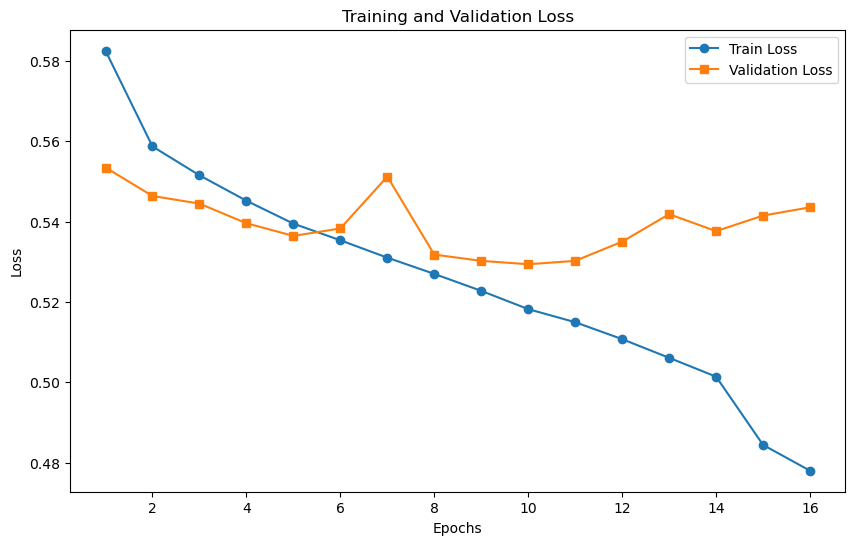

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs,train.train_losses, label='Train Loss', marker='o' )
plt.plot(epochs, train.val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


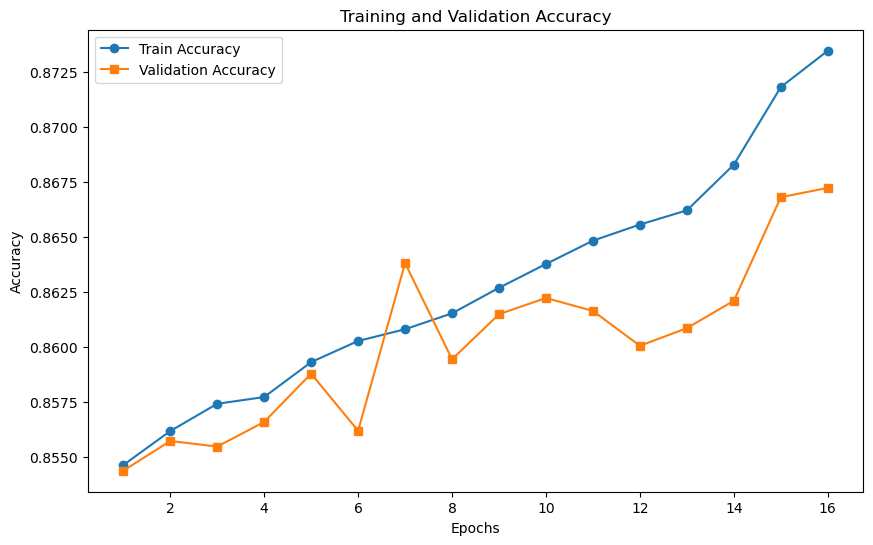

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs,train.train_accuracy, label='Train Accuracy', marker='o' )
plt.plot(epochs, train.val_accuracy, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

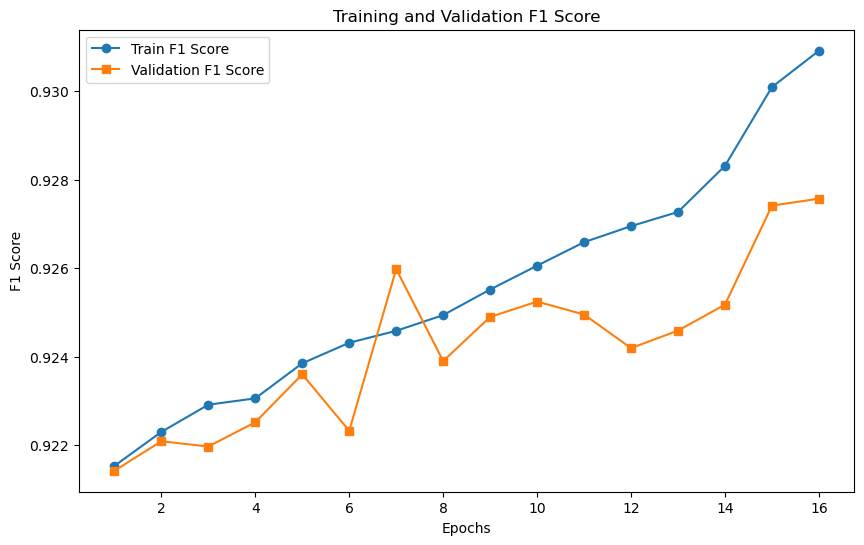

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs,train.train_f1, label='Train F1 Score', marker='o' )
plt.plot(epochs, train.val_f1, label='Validation F1 Score', marker='s')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()
plt.show()

In [4]:
df_test.dropna(subset=['reviewTextProcess', 'sentiment'], inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_test['reviewTextProcess'].isna().sum()

0

In [5]:
texts_test = tokenize_and_vectorize_transformers(df_test['reviewTextProcess'].tolist())

Embeddings guardados en ./embeddings/embeddings_bert.pkl


In [77]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

model = DeepModelGRU(input_dim=768)
model.load_state_dict(torch.load("./model/best_model_deep_0.5277.pth", map_location=device, weights_only=False))
model.to(device)
model.eval()

DeepModelGRU(
  (gru): GRU(768, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [78]:
y_test = df_test['sentiment'].values  
X_test_tensor = torch.tensor(texts_test, dtype=torch.float32).to(device) 
X_test_tensor=X_test_tensor.unsqueeze(1)

In [79]:
X_test_tensor.shape

torch.Size([59267, 1, 768])

In [80]:
y_test= torch.tensor(y_test, dtype=torch.float32)

In [81]:
y_test.shape

torch.Size([59267])

In [93]:
with torch.no_grad():
    y_scores = model(X_test_tensor)
    y_probs = torch.sigmoid(y_scores).cpu().numpy()
    y_pred = (y_probs > 0.7).astype(int) 

In [94]:

print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))




🔹 Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.17      0.28      8664
         1.0       0.88      0.99      0.93     50603

    accuracy                           0.87     59267
   macro avg       0.83      0.58      0.61     59267
weighted avg       0.86      0.87      0.84     59267



In [96]:
conf_matrix

array([[ 1501,  7163],
       [  426, 50177]], dtype=int64)

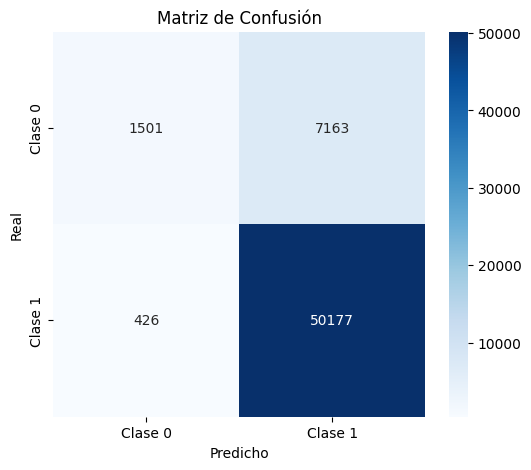

In [97]:
conf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()   

Clase 1 tiene un alto recall (0.99), lo que indica que la mayoría de los ejemplos positivos son detectados correctamente.
Clase 0 tiene un recall bajo (0.17), lo que significa que el modelo no está detectando correctamente los ejemplos negativos.
El modelo está sesgado hacia la Clase 1 y necesita ajustes para mejorar la detección de la Clase 0.

7163 ejemplos de la clase 0 fueron clasificados erróneamente como clase 1.
Solo 1501 ejemplos de la clase 0 fueron correctamente clasificados.
426 ejemplos de la clase 1 fueron clasificados erróneamente como clase 0.

| Métrica             | TF-IDF | DeepLGRU |
|---------------------|--------|----------|
| **Accuracy**       | 0.87   | 0.89     |
| **Recall (Clase 0)** | 0.17   | 0.41     |
| **Recall (Clase 1)** | 0.99   | 0.98     |
| **F1-score (Clase 0)** | 0.28   | 0.53     |

---

✅ **TF-IDF con el nuevo umbral es significativamente mejor que el DeepLGRU.**  
🔹 Detecta más ejemplos de la Clase 0, reduciendo el sesgo hacia la Clase 1.  
🔹 El próximo paso podría ser optimizar aún más el umbral o aplicar técnicas de balanceo adicionales.  